# README
This notebook runs k-means clustering on the base dataset with joint detection data.

The model from this file is discussed in the paper in table 6 as K-means (joint) base

# Load data

In [ ]:
!pip install datasets

from datasets import load_dataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 9.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
!pip install mediapipe

#mediapipe dependencies
import mediapipe as mp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 6.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manyli

In [ ]:
#torch dependencies
from torch.utils.data import DataLoader
from transformers import AutoImageProcessor, ResNetForImageClassification
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image
import torchvision
import torch
from sklearn.metrics import accuracy_score, classification_report

#general dependencies
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import shutil
import os

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting tool

In [ ]:
# Stringify a numeric label into textual form
def decode_label(label):
    if label == 1:
        return "rock"
    elif label == 0:
        return "paper"
    elif label == 2:
        return "scissors"
    elif label == 3:
        return "none"
    return None
    # return "rock" if label == 1 else "paper" if label == 0 else "scissors"

# grey scale images (channel 1)
def grey_scale():
  transform = transforms.Compose([
      transforms.Resize(256),
      transforms.Grayscale(num_output_channels=1),
  ])
  return transform

# returns a transformed image of shape (300, 300, 3)
def rgb_image_transform(image): # input type PIL.PngImagePlugin.PngImageFile
  resized_image = image.resize((300, 300))
  if resized_image.mode != 'RGB':
    resized_image = resized_image.convert('RGB')

  return resized_image

# returns a numpy (tensor) of an image
def image_numpy(image):
  np_image = np.array(image)

  return np_image


In [ ]:
ds = load_dataset("conjunct/rps_annotated")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/9170 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2035 [00:00<?, ? examples/s]

In [ ]:
ds = ds.filter(lambda x: x['src'] == 0)

Filter:   0%|          | 0/9170 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2035 [00:00<?, ? examples/s]

# K-Means

In [ ]:
#Utility from Henry
from scipy.spatial.distance import euclidean
import numpy as np
import re
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

def calculate_distances(landmarks):
    wrist = landmarks[0]
    fingertips_indexes = [4, 8, 12, 16]
    distances = [euclidean(wrist, landmarks[i]) for i in fingertips_indexes]
    return distances

In [ ]:
from itertools import chain

labels = []
labels_test = []

NUM_DISTANCES = 4 # len(calculate_distances(ds_v3['train'][4100]['landmarks']))
for i, row in enumerate(ds['train']):
    landmarks = row['landmarks']
    if landmarks:
        labels.append(row['label'])
        if row['label'] == 3:
            print(f"Landmark detected for train row {i}")
    else:
        pass
        # features.append([0] * NUM_DISTANCES)


for i, row in enumerate(ds['test']):
    landmarks = row['landmarks']
    if landmarks:
        labels_test.append(row['label'])
        if row['label'] == 3:
            print(f"Landmark detected for test row {i}")
    else:
        # features
        pass


labels_array = np.array(labels)
labels_array_test = np.array(labels_test)

In [ ]:
from itertools import chain

features_dists_noz = []
features_dists_noz_test = []

NUM_DISTANCES = 4 # len(calculate_distances(ds_v3['train'][4100]['landmarks']))
for row in ds['train']:
    landmarks = row['landmarks']
    if landmarks:
        remove_z = [(x, y) for (x, y, _) in landmarks]
        distances = calculate_distances(remove_z)
        features_dists_noz.append(distances)
    else:
        pass


for row in ds['test']:
    landmarks = row['landmarks']
    if landmarks:
        remove_z = [(x, y) for (x, y, _) in landmarks]
        distances = calculate_distances(remove_z)
        features_dists_noz_test.append(distances) # flatten list
    else:
        # features
        pass

In [ ]:
features_array_dists = np.array(features_dists_noz)
features_array_dists_test = np.array(features_dists_noz_test)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy: 0.801984126984127
Classification report:
              precision    recall  f1-score   support

           0       0.68      0.96      0.80       840
           1       0.83      0.70      0.76       840
           2       1.00      0.74      0.85       840

    accuracy                           0.80      2520
   macro avg       0.84      0.80      0.80      2520
weighted avg       0.84      0.80      0.80      2520



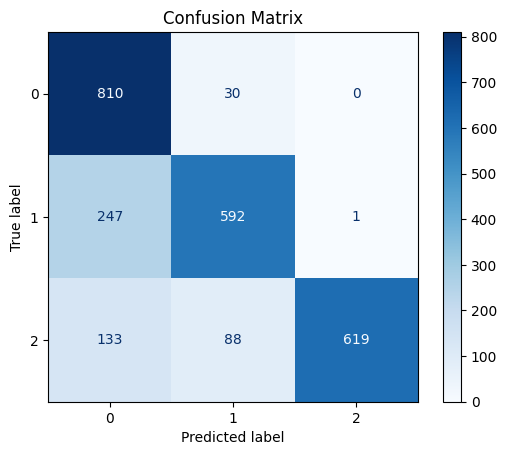

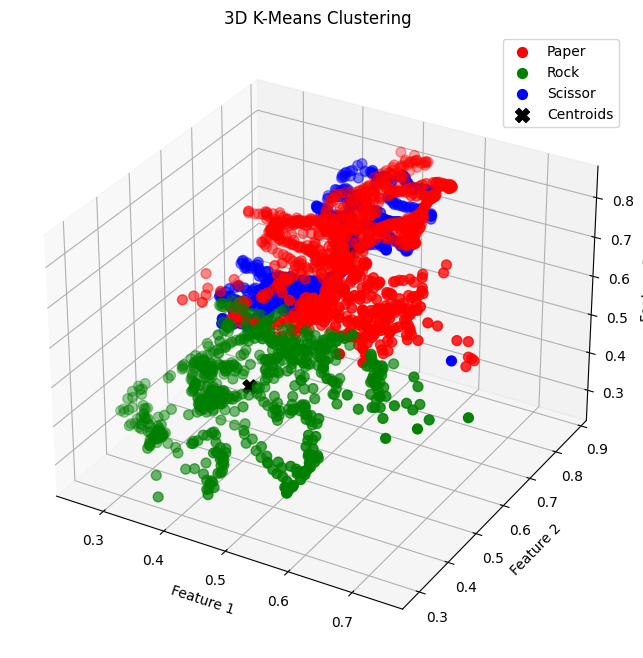

In [ ]:
# NOTE: You may need to rerun this code multiple times. The labels from kmeans
# do not match up with the labels in the order of rock, paper, and scissors
# you know that the run placed the correct labels when the confusion matrix looks diagonal

df = pd.DataFrame(features_array_dists, columns=['x', 'y', 'z', 'm'])

kmeans = KMeans(n_clusters=3)


kmeans.fit(df)


df['cluster'] = kmeans.predict(df)
centroids = kmeans.cluster_centers_


cluster_labels = {0: 'Paper', 1: 'Rock', 2: 'Scissor'}

kmeans_labels = kmeans.labels_

print("Accuracy:", accuracy_score(labels_array, kmeans_labels))
print("Classification report:")
print(classification_report(labels_array, kmeans_labels))

cm = confusion_matrix(labels_array, kmeans_labels, labels=[0, 1, 2])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cluster_labels)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['red', 'green', 'blue']

for i in range(3):
    points = df[df['cluster'] == i]
    ax.scatter(points['x'], points['y'], points['z'], s=50, color=colors[i], label=f'{cluster_labels[i]}')

ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], s=100, color='black', marker='X', label='Centroids')
ax.set_title('3D K-Means Clustering')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
ax.legend()
plt.show()